## Loading the dataset and the neural network classes from their respective notebooks using the _ipynb_ package

In [1]:
from ipynb.fs.full.Dataset import *
from ipynb.fs.full.Network import *

## Loading Necessary Packages

In [23]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import time
import sys
import os
import optuna
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Details about the input data from the _CAMELS_ project

In [6]:
# locations of the CMD maps and the cosmological parameters
fparams = '/mnt/ceph/users/camels/PUBLIC_RELEASE/CMD/2D_maps/data/params_IllustrisTNG.txt'
fmaps2 = '/mnt/ceph/users/camels/PUBLIC_RELEASE/CMD/2D_maps/data/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy'
fmaps_norm = [None]
seed = 1         # random seed
channels = 1     # considering a single field
splits = 15      # choosing all 15 maps per simulation

#case = 'min'
#case = 'max'
case = 'original'

## Function to apply different kinds of pixel density based augmentations and cut on the 2D maps

In [7]:
def augment_maps(dens_cut_str):
    
    import numpy as np
    
    maps = np.load(fmaps2)

    dens_cut = float(dens_cut_str)

    maps_1 = np.zeros((15000,256,256))
    
    # if case is 'min', every value lesser than 'dens_cut' is set as 'dens_cut' while values
    # above 'dens_cut' are not affected
    if case == 'min':
        maps_1 = np.where(maps > dens_cut, maps, dens_cut)       
        
    # if case is 'max', every value greater than 'dens_cut' is set as 'dens_cut' while values
    # lower than 'dens_cut' are not affected
    elif case == 'max':
        maps_1 = np.where(maps < dens_cut, maps, dens_cut)
        
    # if case is 'random_min', every value lesser than 'dens_cut' is replaced with a random uniformly
    # sampled floating point value in the range [min(data), max(data)]
    elif case == 'random_min':
        indexes = np.where(maps<dens_cut)
        maps[indexes] = 10**(np.random.uniform(np.log10(4598096400.0), np.log10(3186287300000000.0), len(indexes[0])))
        
    # if case is 'random_min', every value greater than 'dens_cut' is replaced with a random uniformly
    # sampled floating point value in the range [min(data), max(data)]
    elif case == 'random_max':
        indexes = np.where(maps>dens_cut)
        maps[indexes] = 10**(np.random.uniform(np.log10(4598096400.0), np.log10(3186287300000000.0), len(indexes[0])))
        
    #saving rhe augmented maps
    fmaps_save = '/mnt/ceph/users/alahiry/maps/{}_density/maps_Mtot_TNG_final_{}.npy'.format(case, dens_cut_str)
    with open(fmaps_save, 'wb') as f:
        np.save(f, maps)

## Applying the appropriate augmentation

In [8]:
#the value of dens_cut_str is irrelevant when the case is 'original'
dens_cut_str = None
#augment_maps(dens_cut_str)

## The location of the input maps based on cut being employed

In [11]:
if case == 'original':
    fmaps = ['/mnt/ceph/users/camels/PUBLIC_RELEASE/CMD/2D_maps/data/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy'] 
else:
    fmaps = ['/mnt/ceph/users/alahiry/maps/{}_density/maps_Mtot_TNG_final_{}.npy'.format(case, dens_cut_str)] 

print('Maps location:',fmaps[0])

Maps location: /mnt/ceph/users/camels/PUBLIC_RELEASE/CMD/2D_maps/data/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy


## Displaying one map in log scale for visualisation

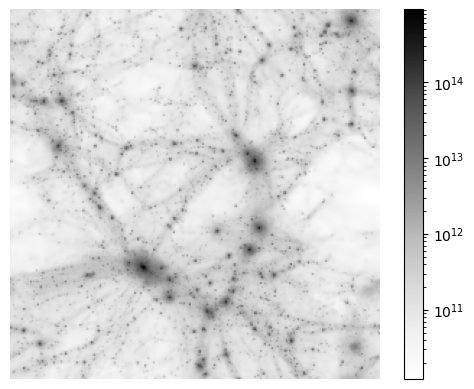

In [ ]:
maps = np.load(fmaps[0])
plt.style.use('default')
plt.imshow(maps[0], norm = mcolors.LogNorm(), cmap = 'Greys')
plt.colorbar()
plt.grid()
plt.axis('off')
plt.show()

## Creating PyTorch DataLoaders for training and validation

In [24]:
start = time.time()

batch_size = 128

# training set
print('\nPreparing training set')
train_dl = create_dataloader('train', seed, fmaps, fparams, batch_size, splits, fmaps_norm, rot_flip_in_mem=False, verbose=True)

#validation set
print('\nPreparing validation set')
valid_dl = create_dataloader('valid', seed, fmaps, fparams, batch_size, splits, fmaps_norm, rot_flip_in_mem=False, verbose=True) 


stop = time.time()

print('\nTime taken to form the training and validation datasets: {:.4f} hrs:'.format((stop-start)/3600.0))


Preparing training set
Found 1 channels
Reading data...
4.598e+09 < F(all|original) < 2.928e+15
9.663 < F(all|rescaled)  < 15.466
-2.931 < F(all|normalized) < 8.872
Channel 0 contains 13500 maps
-2.931 < F < 8.872
train dataset created!


Preparing validation set
Found 1 channels
Reading data...
4.598e+09 < F(all|original) < 2.928e+15
9.663 < F(all|rescaled)  < 15.466
-2.931 < F(all|normalized) < 8.872
Channel 0 contains 750 maps
-2.931 < F < 8.872
valid dataset created!


Time taken to form the training and validation datasets: 0.0161 hrs:


## Checking if GPUs are available, and if yes, the number of devices for use

In [13]:
# use GPUs if available
import torch.backends.cudnn as cudnn

if torch.cuda.is_available():
    print("Using CUDA")
    #index = 0
    #torch.cuda.set_device(index)
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device1 = torch.device('cpu')
cudnn.benchmark = True      #May train faster but cost more memory


if (device == torch.device('cuda')):
    if torch.cuda.device_count() > 1:
        print("%d GPUs Available"%(torch.cuda.device_count()))
    print('GPU model:',torch.cuda.get_device_name())

else:
    print('Using CPU (Cuda unavailable)\n')
    

#print('Currently using device #:',torch.cuda.current_device())

Using CUDA
3 GPUs Available
GPU model: Tesla V100-SXM2-32GB


## Different value in _params_ correspond to each of the 6 cosmological and astrophysical parameters. Defining _params_ would define which parameter the model would be focussing on

In [14]:
params = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g = params                #g will contain the mean of the posterior
h = [6+i for i in g]      #h will contain the variance of the posterior

## Setting the location to save the model weights and the _Optuna_ database, and creating the folder if it does not already exist

In [21]:
if case == 'original':
    dir_wt = '/mnt/ceph/users/alahiry/density/{}'.format(case)
else:
    dir_wt = '/mnt/ceph/users/alahiry/density/{}/{}'.format(case, dens_cut_str)
if not os.path.exists(dir_wt):
    os.makedirs(dir_wt)  # create folder if it does not exist
    
print('Folder: ' + dir_wt)

Folder: /mnt/ceph/users/alahiry/density/original


## Main training and hyperparameter optimisation:

### (50 _Optuna_ trials and 200 epochs of training in each trial)

In [ ]:
import torch.nn as nn

def fit(params, epochs, model, train_dl, valid_dl, trial):

    min_valid_loss = 10**(34)

    max_lr = params['max_lr']
    wd = params["wd"]

    # optimizer parameters
    beta1 = 0.5
    beta2 = 0.999

    optimizer = torch.optim.AdamW(model.parameters(), lr = max_lr, weight_decay = wd, betas=(beta1, beta2))
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr = 1e-09, max_lr = max_lr, cycle_momentum=False, step_size_up=500, step_size_down=500)

    for epoch in range(epochs):  # loop over the dataset multiple times

        #training model
        train_loss1, train_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
        train_loss, points = 0.0, 0
        model.train()
        for x, y in train_dl:
            bs   = x.shape[0]         #batch size
            x    = x.to(device)       #maps
            y    = y.to(device)[:,g]  #parameters
            p    = model(x)           #NN output
            y_NN = p[:,g]             #posterior mean
            e_NN = p[:,h]             #posterior std
            loss1 = torch.mean((y_NN - y)**2,                axis=0)
            loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
            loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
            train_loss1 += loss1*bs
            train_loss2 += loss2*bs
            points      += bs
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
        train_loss = torch.log(train_loss1/points) + torch.log(train_loss2/points)
        train_loss = torch.mean(train_loss).item()

        #evaluating with validation set
        valid_loss1, valid_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
        valid_loss, points = 0.0, 0
        model.eval()
        for x, y in valid_dl:
            with torch.no_grad():
                bs    = x.shape[0]         #batch size
                x     = x.to(device)       #maps
                y     = y.to(device)[:,g]  #parameters
                p     = model(x)           #NN output
                y_NN  = p[:,g]             #posterior mean
                e_NN  = p[:,h]             #posterior std
                loss1 = torch.mean((y_NN - y)**2,                axis=0)
                loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
                loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
                valid_loss1 += loss1*bs
                valid_loss2 += loss2*bs
                points     += bs
        valid_loss = torch.log(valid_loss1/points) + torch.log(valid_loss2/points)
        valid_loss = torch.mean(valid_loss).item()


        #saving the model if the loss is better(lower) than the previous epoch
        if valid_loss < min_valid_loss:
            fweights = dir_wt + '/weights_{}.pt'.format(trial.number)  
            torch.save(model.state_dict(), fweights)
            min_valid_loss = valid_loss

        floss = dir_wt + '/losses_{}.txt'.format(trial.number)  
        #saving epoch, training and validation losses to a text file
        f = open(floss, 'a')
        f.write('%d %.5e %.5e\n'%(epoch, train_loss, valid_loss))
        f.close()
        
    return min_valid_loss
    torch.cuda.empty_cache()


def objective(trial):

    # hyperparameters to optimise
    params = {
            'max_lr': trial.suggest_float("max_lr", 1e-5, 5e-3, log=True),
            'wd': trial.suggest_float("wd", 1e-8, 1e-1, log=True),
            'dr': trial.suggest_float("dr", 0.0,  0.9),
            'hidden': trial.suggest_int("hidden", 6, 12)
            }
    
    # defining the model with these parameters for each optuna trial
    model = Model_CMD(params,channels)

    # use GPUs if available
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    cudnn.benchmark = True                    #May train faster but cost more memory
    if (device == torch.device('cuda')):
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    epochs = 200
    loss_fin = fit(params,epochs, model, train_dl, valid_dl, trial)

    return loss_fin


if case == 'original':
    study_name = 'Mtot_dens_{}'.format(dens_cut_str)
    storage    = 'sqlite:///{}/Mtot_dens_{}.db'.format(dir_wt, dens_cut_str)

else:
    study_name = 'Mtot_dens_{}_{}'.format(case, dens_cut_str)
    storage    = 'sqlite:///{}/Mtot_dens_{}_{}.db'.format(dir_wt, case, dens_cut_str)

start = time.time()

# optimising hyperparameters to minimise the loss function
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), study_name = study_name, storage = storage, load_if_exists = True)
study.optimize(objective, n_trials = 50)

stop = time.time()

print('\nTime taken : {:.4f} hrs:'.format((stop-start)/3600.0))


[I 2023-02-04 06:13:05,402] Using an existing study with name 'Mtot_dens_random_max_1e15' instead of creating a new one.
[I 2023-02-04 07:09:39,829] Trial 15 finished with value: -11.67689323425293 and parameters: {'max_lr': 0.0005378973923104779, 'wd': 3.072014900633686e-06, 'dr': 0.5226621770590207, 'hidden': 10}. Best is trial 4 with value: -12.609004020690918.
[I 2023-02-04 08:14:41,134] Trial 16 finished with value: -12.638189315795898 and parameters: {'max_lr': 0.002455539816866881, 'wd': 3.094461193468979e-06, 'dr': 0.19529995974432546, 'hidden': 12}. Best is trial 16 with value: -12.638189315795898.
[I 2023-02-04 09:06:39,934] Trial 17 finished with value: -12.651961326599121 and parameters: {'max_lr': 0.00299329498500207, 'wd': 0.0009113911495295286, 'dr': 0.22193554760520384, 'hidden': 9}. Best is trial 17 with value: -12.651961326599121.
[I 2023-02-04 09:58:13,920] Trial 18 finished with value: -12.640520095825195 and parameters: {'max_lr': 0.0033486663558743466, 'wd': 0.000

## Loading _Optuna_ database and checking the best model parameters

In [22]:
#optuna parameters
if case == 'original':
    study_name = 'Mtot_dens_{}'.format(case)
    storage    = 'sqlite:///{}/Mtot_dens_{}.db'.format(dir_wt, case)

else:
    study_name = 'Mtot_dens_{}_{}'.format(case, dens_cut_str)
    storage    = 'sqlite:///{}/Mtot_dens_{}_{}.db'.format(dir_wt, case, dens_cut_str)

study = optuna.load_study(study_name = study_name, storage = storage)

best_trial = study.best_trial

print('\nBest model parameters:\n')
for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))
print('\nBest Loss = ', best_trial.value)

params_final = best_trial.params

print('\nBest trial number:', best_trial.number)


Best model parameters:

dr: 0.20897243577745028
hidden: 7
max_lr: 0.004878349997109824
wd: 0.0002441901072777639

Best Loss =  -12.611610412597656

Best trial number: 10
